# Importing Libraries

In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import tqdm
import os

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
key = jax.random.PRNGKey(0)
np.random.seed(0)

# Basic Environment Setup

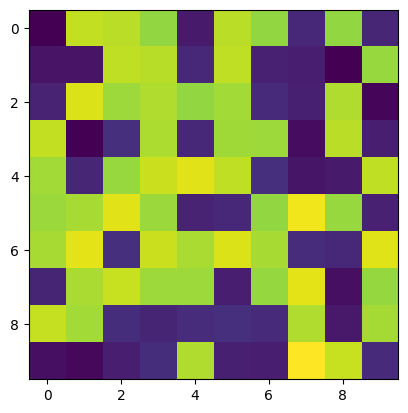

In [2]:
SIZE = [10,10]

@jax.jit
def map_gen(sparsity):
    res = jax.random.uniform(key,shape = SIZE)
    return jnp.where(res <= sparsity, 0, 1) + jax.random.normal(key,shape = SIZE)*0.1

sing_map = map_gen(0.5)
plt.imshow(sing_map)
plt.show()

# Basic sender and reciever positioning

In [3]:
def random_side_coordinate():
    base = np.zeros(4)
    if np.random.uniform() < 0.5:
        base[0] = np.random.randint(0,SIZE[0])
    else:
        base[1] = np.random.randint(0,SIZE[0])
    if np.random.uniform() < 0.5:
        base[2] = np.random.randint(0,SIZE[0])
    else:
        base[3] = np.random.randint(0,SIZE[0])
    return base

coordinates = random_side_coordinate()

# Calculation of A and B matrix

In [4]:
def bresenham_line(x1, y1, x2, y2):
    line_points = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    step_x = 1 if x1 < x2 else -1
    step_y = 1 if y1 < y2 else -1
    error = dx - dy

    while True:
        line_points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        double_error = 2 * error
        if double_error > -dy:
            error -= dy
            x1 += step_x
        if double_error < dx:
            error += dx
            y1 += step_y

    return line_points

def find_cut_indices(matrix,coordinates):
    x1, y1, x2, y2 = coordinates
    cut_indices = []
    line_points = bresenham_line(x1, y1, x2, y2)

    for x, y in line_points:
        if 0 <= x < len(matrix) and 0 <= y < len(matrix[0]):
            cut_indices.append((int(x), int(y)))
    return cut_indices

def attenuation_result(attenuation_map, coordinates):
    cuts = find_cut_indices(attenuation_map, coordinates)
    mask = np.zeros_like(attenuation_map)
    for i in cuts:
        mask[i] = 1
    A_vector = mask.astype(np.float32)
    B_vector = np.dot(A_vector.reshape(-1),
                        attenuation_map.reshape(-1, 1))
    return (A_vector.reshape(-1,), B_vector)

In [5]:
A,B = attenuation_result(sing_map,coordinates)
A,B

(array([0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([1.9939064], dtype=float32))

# General Env setup for time step to be 10

In [6]:
TIME_STAMP = 250
np.random.seed(0)

points = [random_side_coordinate() for i in range(TIME_STAMP)]
A_B = [attenuation_result(sing_map,point) for point in points]

In [7]:
@jax.jit
def solver(A, B):
    term1 = jnp.linalg.pinv(jnp.dot(A.T, A))
    term2 = jnp.dot(A.T, B)
    X = jnp.dot(term1, term2)
    return X

@jax.jit
def PCA_low_rank(A):
    U,sigma,V = jnp.linalg.svd(A)
    explained_variances = (sigma ** 2) / (len(sigma) - 1)
    cumulative_explained_variances = jnp.cumsum(explained_variances) / jnp.sum(explained_variances)
    num_components = jax.lax.while_loop(lambda x:cumulative_explained_variances[x]<=0.998,lambda x:x+1,0)
    pca_result = jnp.zeros((len(U),len(V)))
    pca_result = jax.lax.fori_loop(0,num_components,lambda i,val: jnp.outer(U.T[i],V[i])+val,pca_result)
    return pca_result

# @jax.jit
def pca_evd(data):
    mean_data = jnp.mean(data, axis=0)
    centered_data = data - mean_data
    cov_matrix = jnp.cov(centered_data, rowvar=False)
    eigenvalues, eigenvectors = jnp.linalg.eigh(cov_matrix)
    sorted_indices = jnp.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    num_components = 2
    projected_data = jnp.dot(centered_data, eigenvectors[:, :num_components])
    reconstructed_data = jnp.dot(projected_data, eigenvectors[:, :num_components].T)
    reconstructed_data += mean_data
    return projected_data,reconstructed_data

# @jax.jit
def pca_svd(data):
    mean_data = jnp.mean(data, axis=0)
    centered_data = data - mean_data
    U, S, VT = jnp.linalg.svd(centered_data, full_matrices=False)
    num_components = 2  # Number of principal components to keep
    projected_data = jnp.dot(centered_data, VT[:num_components].T)
    reconstructed_data = jnp.dot(projected_data, VT[:num_components])
    reconstructed_data += mean_data
    return projected_data,reconstructed_data

In [8]:
import time

start = time.time()
pca_svd(jax.random.normal(key, shape=(2, 50)))
print(time.time() - start)

import time

start = time.time()
pca_evd(jax.random.normal(key, shape=(2, 50)))
print(time.time() - start)

0.6994032859802246
0.8369114398956299


# Plotting of the confidence ellipse

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

# Trial Run

  0%|          | 0/249 [00:00<?, ?it/s]

100%|██████████| 249/249 [00:06<00:00, 36.44it/s]


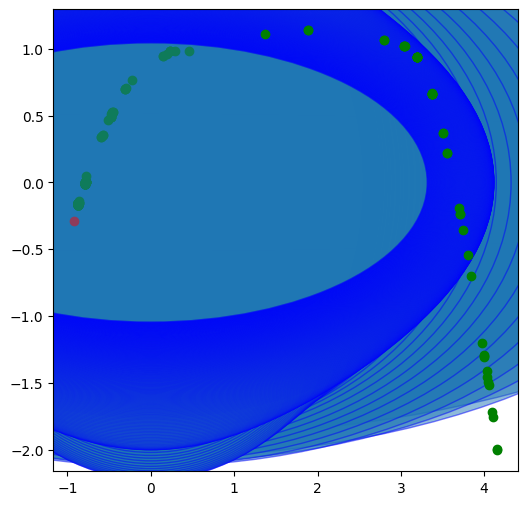

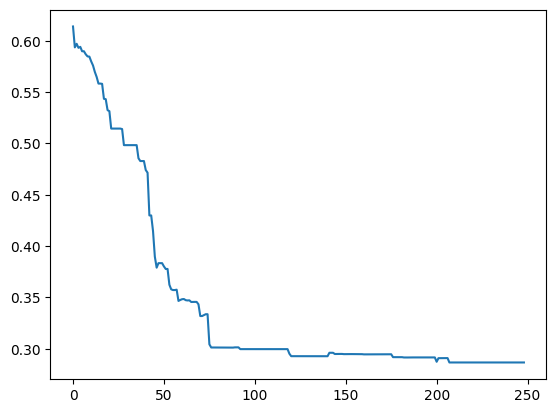

In [17]:
time_knowledge = {}
A,B = [A_B[0][0]],[A_B[0][1]]
REGEN = [sing_map.reshape(-1,),solver(np.array(A),jnp.array(B)).reshape(-1,)]


fig, axs = plt.subplots(1, 1, figsize=(6, 6))
flag = True
MSEs = []
for ind in tqdm.tqdm(range(1,len(A_B))):
    A.append(A_B[ind][0])
    B.append(A_B[ind][1])
    
    A_temp,B_temp = jnp.array(A),jnp.array(B)
    regen = solver(A_temp,B_temp)
    REGEN.append(regen.reshape(-1,))
    REGEN_temp = jnp.array(REGEN)
    MSEs.append(jnp.sqrt(jnp.square(regen.reshape(SIZE) - sing_map)).mean())
    PCA_S = pca_evd(REGEN_temp)[0]

    pca_s = jnp.array(PCA_S)
    x,y = pca_s[:,0].reshape(-1,),pca_s[:,1].reshape(-1,)
    
    pos = pca_s.mean(axis=0)
    cov = np.cov(pca_s,rowvar=False)
    
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    width, height = 2 * 2 * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, edgecolor='blue',alpha = 0.5)

    axs.add_artist(ellip)

axs.scatter(x[:1],y[:1],color = 'red')
axs.scatter(x[1:],y[1:],color = 'green')
plot_point_cov(pca_s, ax = axs, edgecolor='blue',alpha = 0.5)
plt.show()

plt.plot(MSEs)
plt.show()

# print(REGEN)
    
# Add mse and make the plot good enough
    